In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MultiStateReporter2(MultiStateReporter):
    def read_energies(self, iteration=slice(None)):
        """Retrieve the energy matrix at the given iteration on the analysis file
        Parameters
        ----------
        iteration : int or slice
            The iteration(s) at which to read the data. The slice(None) allows fetching all iterations at once.
        Returns
        -------
        energy_thermodynamic_states : n_replicas x n_states numpy.ndarray
            ``energy_thermodynamic_states[iteration, i, j]`` is the reduced potential computed at
            SamplerState ``sampler_states[iteration, i]`` and ThermodynamicState ``thermodynamic_states[iteration, j]``.
        energy_neighborhoods : n_replicas x n_states numpy.ndarray
            energy_neighborhoods[replica_index, state_index] is 1 if the energy was computed for this state,
            0 otherwise
        energy_unsampled_states : n_replicas x n_unsampled_states numpy.ndarray
            ``energy_unsampled_states[iteration, i, j]`` is the reduced potential computed at SamplerState
            ``sampler_states[iteration, i]`` and ThermodynamicState ``unsampled_thermodynamic_states[iteration, j]``.
        """
        # Determine last consistent iteration
        iteration = self._map_iteration_to_good(iteration)
        # Retrieve energies at all thermodynamic states
        energy_thermodynamic_states = np.array(self._storage_analysis.variables['energies'][iteration, :, :], np.float64)
        # Retrieve neighborhoods, assuming global neighborhoods if reading a pre-neighborhoods file
        try:
            energy_neighborhoods = np.array(self._storage_analysis.variables['neighborhoods'][iteration, :, :], 'i1')
        except KeyError:
            energy_neighborhoods = np.ones(energy_thermodynamic_states.shape, 'i1')
        # Read energies at unsampled states, if present
#         try:
#             energy_unsampled_states = np.array(self._storage_analysis.variables['unsampled_energies'][iteration, :, :], np.float64)
#         except KeyError:
#             # There are no unsampled thermodynamic states.
        unsampled_shape = energy_thermodynamic_states.shape[:-1] + (0,)
        energy_unsampled_states = np.zeros(unsampled_shape)
        return energy_thermodynamic_states, energy_neighborhoods, energy_unsampled_states


In [3]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter2(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
    iterations_to_analyze = range(1, n_iterations, 100)
    print(list(iterations_to_analyze)) # check that this is giving me the last avail iteration
    for step in iterations_to_analyze: 
        analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
        f_ij, df_ij = analyzer.get_free_energy()
        dg.append(f_ij[0,-1])
        ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    print("Neff: ", analyzer.mbar.computeEffectiveSampleNumber())
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg), f_ij, df_ij

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/4)

In [4]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [9]:
main_dir = 32
sub_dir = 3
chunk = 4
titles = ['ALA->THR']

In [10]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as /data/chodera/zhangi/perses_benchmark/repex/32/3/4/4_apo_checkpoint.nc
DEBUG:openmmtools.multistate.multistatereporter:checkpoint_interval != on-file checkpoint interval! Using on file analysis interval of 10.
DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...


analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to equilibration : 1
DEBUG:openmmtools.multistate.multistateanalyzer: statistical ineffic

DEBUG:openmmtools.multistate.multistateanalyzer:   8.050   8.050  15.277  16.830  16.706  14.963  11.601   6.614   0.000  -8.245 -18.134 -29.674
DEBUG:openmmtools.multistate.multistateanalyzer:  16.296  16.296  23.522  25.076  24.951  23.209  19.846  14.859   8.245   0.000  -9.889 -21.429
DEBUG:openmmtools.multistate.multistateanalyzer:  26.184  26.184  33.411  34.964  34.840  33.097  29.735  24.748  18.134   9.889   0.000 -11.540
DEBUG:openmmtools.multistate.multistateanalyzer:  37.725  37.725  44.951  46.505  46.380  44.637  41.275  36.288  29.674  21.429  11.540   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.501   0.531   0.539   0.545   0.550   0.554   0.559   0.564   0.569   0.577
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.501   0.531   0.539   0.545   0.550   0.554   0.559   0.564   0.569   0.577
DEBUG:openmmtools.multistate.multistateanalyzer:   0.501   0.501   0.0

DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of the requested keys could be found on disk!
DEBUG:openmmtools.multistate.multistateanalyzer:Equilibration data:
DEBUG:openmmtools.multistate.multistateanalyzer: number of iterations discarded to

DEBUG:openmmtools.multistate.multistateanalyzer:   2.022   2.022   8.645  10.191  10.061   8.320   4.970   0.000  -6.613 -14.891 -24.847 -36.478
DEBUG:openmmtools.multistate.multistateanalyzer:   8.635   8.635  15.258  16.804  16.674  14.933  11.584   6.613   0.000  -8.278 -18.234 -29.865
DEBUG:openmmtools.multistate.multistateanalyzer:  16.913  16.913  23.536  25.081  24.952  23.210  19.861  14.891   8.278   0.000  -9.956 -21.588
DEBUG:openmmtools.multistate.multistateanalyzer:  26.869  26.869  33.492  35.038  34.908  33.167  29.817  24.847  18.234   9.956   0.000 -11.631
DEBUG:openmmtools.multistate.multistateanalyzer:  38.501  38.501  45.123  46.669  46.539  44.798  41.449  36.478  29.865  21.588  11.631   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.256   0.270   0.276   0.279   0.282   0.285   0.288   0.291   0.295   0.299
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.2

DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of

DEBUG:openmmtools.multistate.multistateanalyzer:  -3.392  -3.392   3.713   5.222   5.080   3.340   0.000  -4.956 -11.555 -19.832 -29.814 -41.510
DEBUG:openmmtools.multistate.multistateanalyzer:   1.564   1.564   8.669  10.178  10.036   8.296   4.956   0.000  -6.599 -14.876 -24.858 -36.554
DEBUG:openmmtools.multistate.multistateanalyzer:   8.163   8.163  15.269  16.777  16.636  14.895  11.555   6.599   0.000  -8.276 -18.259 -29.955
DEBUG:openmmtools.multistate.multistateanalyzer:  16.440  16.440  23.545  25.053  24.912  23.172  19.832  14.876   8.276   0.000  -9.983 -21.678
DEBUG:openmmtools.multistate.multistateanalyzer:  26.422  26.422  33.528  35.036  34.895  33.154  29.814  24.858  18.259   9.983   0.000 -11.696
DEBUG:openmmtools.multistate.multistateanalyzer:  38.118  38.118  45.224  46.732  46.590  44.850  41.510  36.554  29.955  21.678  11.696   0.000
DEBUG:openmmtools.multistate.multistateanalyzer:dDeltaf_ij:
DEBUG:openmmtools.multistate.multistateanalyzer:   0.000   0.000   0.2

DEBUG:openmmtools.multistate.multistateanalyzer:Checking if we need to unbias the restraint...
DEBUG:openmmtools.multistate.multistateanalyzer:Trying to get radially symmetric restraint data...
DEBUG:openmmtools.multistate.multistateanalyzer:Retrieving end thermodynamic states...
DEBUG:openmmtools.multistate.multistateanalyzer:Isolating restraint force...
DEBUG:openmmtools.multistate.multistateanalyzer:No force of type <class 'openmmtools.forces.RadiallySymmetricRestraintForce'> could be found. The restraint will not be unbiased.
DEBUG:openmmtools.multistate.multistateanalyzer:Reading energies...
DEBUG:openmmtools.multistate.multistatereporter:read_replica_thermodynamic_states: iteration = [   0    1    2 ...  998  999 1000]
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Assembling effective timeseries...
DEBUG:openmmtools.multistate.multistateanalyzer:Done.
DEBUG:openmmtools.multistate.multistateanalyzer:Could not find t0: None of

DEBUG:openmmtools.multistate.multistateanalyzer:  -6.297  -6.297   0.424   1.905   1.755   0.000  -3.365  -8.355 -14.993 -23.300 -33.289 -44.956
DEBUG:openmmtools.multistate.multistateanalyzer:  -2.932  -2.932   3.789   5.270   5.119   3.365   0.000  -4.990 -11.628 -19.935 -29.924 -41.591
DEBUG:openmmtools.multistate.multistateanalyzer:   2.058   2.058   8.779  10.260  10.110   8.355   4.990   0.000  -6.638 -14.945 -24.934 -36.601
DEBUG:openmmtools.multistate.multistateanalyzer:   8.696   8.696  15.417  16.898  16.748  14.993  11.628   6.638   0.000  -8.307 -18.296 -29.963
DEBUG:openmmtools.multistate.multistateanalyzer:  17.003  17.003  23.724  25.205  25.055  23.300  19.935  14.945   8.307   0.000  -9.989 -21.656
DEBUG:openmmtools.multistate.multistateanalyzer:  26.992  26.992  33.713  35.194  35.044  33.289  29.924  24.934  18.296   9.989   0.000 -11.667
DEBUG:openmmtools.multistate.multistateanalyzer:  38.659  38.659  45.380  46.861  46.710  44.956  41.591  36.601  29.963  21.656  

Neff:  [ 668.89038515  668.89038515  981.51300556 1520.49874899 1880.12488727
 2101.50828034 2209.75421358 2221.54896599 2117.06995302 1854.66148483
 1439.50094301  915.84348525]


In [11]:
apo_dg

array([-39.21296576, -37.72463615, -38.53716837, -38.39705895,
       -38.50063622, -38.17862421, -38.35124147, -38.11819658,
       -38.31774375, -38.41100898, -38.65853916])

In [12]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


4 apo: -38.65853915648068 (0.21727557747086887) kT



In [13]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so ti

<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/5)

In [14]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [15]:
main_dir = 32
sub_dir = 3
chunk = 5
titles = ['ALA->THR']

In [16]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [ 649.25702959  649.25702959  860.49550065 1252.30953095 1504.6118312
 1662.37700236 1744.65428997 1763.1434045  1706.00448989 1537.02235808
 1209.01889313  761.29496991]


In [17]:
apo_dg

array([-42.50101013, -38.33307793, -39.05977027, -38.72376851,
       -38.67653622, -38.76114739, -38.70763242, -38.95061582,
       -38.98956051, -39.07102118, -38.94017239])

In [18]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


5 apo: -38.94017239214564 (0.1558297862742965) kT



In [19]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/6)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [20]:
main_dir = 32
sub_dir = 3
chunk = 6
titles = ['ALA->THR']

In [21]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [1388.74337116 1388.74337116 1763.46684878 1750.74444205 1584.27463036
 1389.71342063 1195.44893583 1019.82976788  976.33710354  992.94093914
  915.48817071  593.87347456]


In [22]:
apo_dg

array([-43.00738931, -38.39344042, -39.05588483, -38.88850358,
       -38.98238814, -39.11804954, -38.99173103, -39.04861424,
       -39.0036419 , -39.11841412, -39.01872324])

In [23]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


6 apo: -39.0187232440423 (0.14254357949478702) kT



In [24]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/7)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [25]:
main_dir = 32
sub_dir = 3
chunk = 7
titles = ['ALA->THR']

In [26]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [1341.12841861 1341.12841861 1822.60798671 1979.33848931 1724.26253688
 1295.73824898 1374.63524793 1110.86978001  819.78317067  762.1290244
  774.58576053  515.5858859 ]


In [27]:
apo_dg

array([-42.74380988, -38.6240959 , -38.22200571, -38.3638059 ,
       -38.44028767, -38.31321952, -38.39956123, -38.42082893,
       -38.55954902, -38.41509335, -38.5361666 ])

In [28]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


7 apo: -38.536166602249374 (0.15751687670279255) kT



In [29]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 1 ns ala -> thr dipeptide in solvent (repex/32/3/8)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [30]:
main_dir = 32
sub_dir = 3
chunk = 8
titles = ['ALA->THR']

In [31]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 1000
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]


Neff:  [1130.45405118 1130.45405118 1785.74133327 1880.67118418 2171.28597904
 2541.43375357 2608.0465826  2306.4396646  1865.76045939 1506.37324208
  582.53503055  357.14734918]


In [32]:
apo_dg

array([-42.11390366, -40.59058058, -40.14123876, -41.10249745,
       -40.78763021, -40.59822938, -40.69113663, -40.52326234,
       -40.82749866, -40.20070211, -40.21330066])

In [33]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


8 apo: -40.2133006616424 (0.27372277652746413) kT



In [34]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas_apo.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

# Plot

In [22]:
d_results = {}

for chunk in [0, 1, 2]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[chunk] = results

In [33]:
d_results[0][0]

array([-38.12848388, -38.66309063, -38.94669624, -38.8946129 ,
       -39.28618639, -39.26468308, -39.38835957, -39.08287784,
       -39.18441832, -39.14291889, -39.12227244, -39.13084332,
       -39.05589916, -39.20434755, -39.0941948 , -39.04045506,
       -39.20053891, -38.99790165, -38.91555136, -39.04663307,
       -39.27321015, -39.06506384, -39.17968253, -39.17069457,
       -38.9937386 , -38.94321439, -38.95875644, -39.0388974 ,
       -38.96543816, -39.03979338, -39.26707353, -39.07335723,
       -38.81083579, -39.06776824, -38.82632   , -38.96534875,
       -39.03490024, -39.14748068, -39.02688908, -39.0842743 ,
       -39.20053972, -39.04572034, -39.03795415, -39.06520762,
       -38.90841608, -38.85193741, -38.98110444, -38.92994466,
       -39.00382515, -38.94174132, -39.05260936])

In [47]:
def plot_series(d_results, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
#     labels = ['No REST', 'T_max = 600 K', 'T_max = 1200 K']
    for r in list(d_results.keys()):
#         dg_discarded = dg[r][7:] # 7 * 200 = 1400 ps discarded
#         ddg_discarded = ddg[r][7:]
        dg_discarded = d_results[r][0]
        ddg_discarded = d_results[r][1]

        # dg
        ax = axes[0]
#         x = [(j)*.2 + 1.4 for j in range(len(dg_discarded))] # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        x = np.array(range(len(dg_discarded)))/10 # *.2 bc computing energy every 200 ps,  1.4 bc discarding first 1400 ps
        y = dg_discarded
#         ax.plot(x, y, color=sns.color_palette()[r], label=f'{labels[r]}')
        ax.plot(x, y, label=f'{r}')
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
#         x = [(j)*.2 + 1.4 for j in range(len(ddg_discarded))]
        x = np.array(range(len(ddg_discarded)))/10
        y = ddg_discarded
#         ax.plot(x, y, color=sns.color_palette()[r])
        ax.plot(x, y)

#         # deviation from mean
#         ax = axes[2]
#         x = [(i)/20 + 1.5 for i in range(len(dg_discarded))]
#         y = np.array(dg_discarded) - mean # Need to the average solvent dg across replicates
#         ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
#     axes[2].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    axes[0].legend()
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/{chunk}_{phase}_series.png", dpi=500)
#     plt.clf()

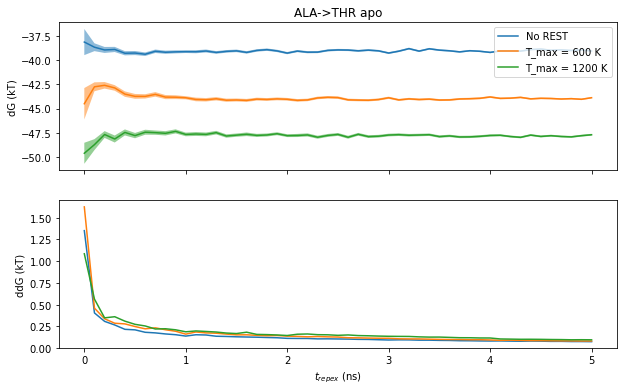

In [55]:
plot_series(d_results, 'apo', 'ALA->THR')

In [36]:
d_results = {}

for chunk in [4, 5, 6, 7, 8]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[chunk] = results

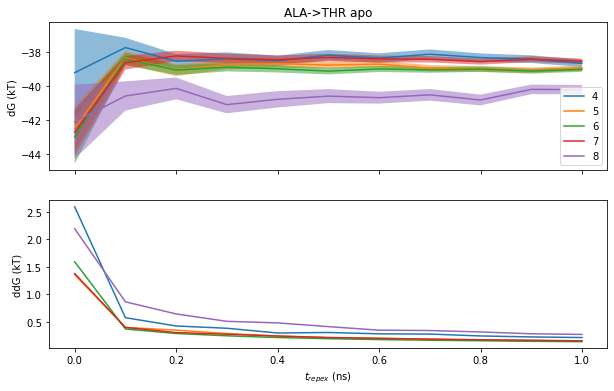

In [48]:
plot_series(d_results, 'apo', 'ALA->THR')